# Create Images

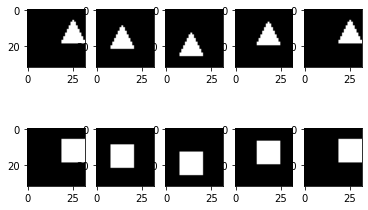

In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

np.random.seed(23)

num_objects = 100
patch_size = 32
object_size = 13
offset = object_size // 2

# calculate 'center' point range
c_start = offset
c_end = patch_size - offset


images = []
labels = [] # 0:triangle, 1:square


# create objects
for i in range(num_objects):
    
    
    # create a random 'center' point
    x, y = np.random.randint(c_start,c_end,2)
    
    # create a triangle
    pts_triangle = np.array([[x,y-offset],[x-offset,y+offset],[x+offset,y+offset]],dtype=int)
    
    canvas_triangle = np.zeros((patch_size,patch_size), dtype=np.float32)
#     canvas_triangle = -1*np.ones((patch_size,patch_size), dtype=np.float32)
    cv2.drawContours(canvas_triangle, [pts_triangle], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA
    
    images.append(canvas_triangle)
    labels.append(0)
    
    # create a square
    pts_square = np.array([[x-offset,y-offset],[x-offset,y+offset],[x+offset,y+offset],[x+offset,y-offset]],dtype=int)
    
    canvas_square = np.zeros((patch_size,patch_size), dtype=np.float32)
#     canvas_square = -1*np.ones((patch_size,patch_size), dtype=np.float32)
    cv2.drawContours(canvas_square, [pts_square], 0, (1), -1, cv2.LINE_4)
    
    images.append(canvas_square)
    labels.append(1)

# visualize 5 images of each object
fig,ax = plt.subplots(2,5)
for i in range(5):
    ax[0,i].set_aspect('equal')
    ax[0,i].imshow(images[2*i], cmap='gray')
    
    ax[1,i].set_aspect('equal')
    ax[1,i].imshow(images[2*i+1], cmap='gray')

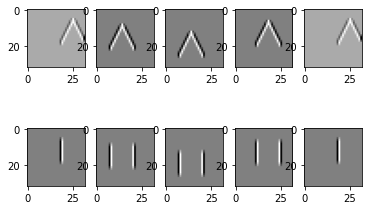

In [2]:
# image filtering

# filter_arr = np.array([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]], dtype=np.float32)
# filter_arr = np.array([[-1.,-1.,0.,1.,1.],[-1.,-1.,0.,1.,1.],[-1.,-1.,0.,1.,1.],[-1.,-1.,0.,1.,1.],[-1.,-1.,0.,1.,1.]], dtype=np.float32)
filter_arr = np.array([[-1.,2.,-1.],[-1.,2.,-1.],[-1.,2.,-1.]], dtype=np.float32)

filtered_images = []
for i in range(len(images)):
    filtered_img = cv2.filter2D(images[i],-1,filter_arr)
    
    filtered_images.append(filtered_img)

# visualize 5 filtered images of each objectL
fig,ax = plt.subplots(2,5)
for i in range(5):
    ax[0,i].set_aspect('equal')
    ax[0,i].imshow(filtered_images[2*i], cmap='gray')
    
    ax[1,i].set_aspect('equal')
    ax[1,i].imshow(filtered_images[2*i+1], cmap='gray')
    

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data


class CNN(nn.Module):
    def __init__(self, num_features=1):
        super().__init__()
        
        torch.manual_seed(29)
        
        self.num_features = num_features
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_features, kernel_size=5, bias=True)
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=5, bias=True)
        self.conv3 = nn.Conv2d(num_features, num_features, kernel_size=3, bias=True)
        self.fc1 = nn.Linear(num_features*3*3, 2, bias=True)
        
    def forward(self, x):
        y1 = self.conv1(x)
        z1 = F.relu(y1)
        s1 = F.max_pool2d(z1, kernel_size=2)
        y2 = self.conv2(s1)
        z2 = F.relu(y2)
        s2 = F.max_pool2d(z2, kernel_size=2)
        y3 = self.conv3(s2)
        z3 = F.relu(y3)
        z3 = z3.view(-1, self.num_features*3*3)
        y4 = self.fc1(z3)
        
        return y1,z1,s1,y2,z2,s2,y3,z3,y4

    

    

In [4]:
# convert to tensors
images = torch.as_tensor(images, dtype=torch.float32).view(-1,1,patch_size,patch_size)
labels = torch.as_tensor(labels, dtype=torch.long)

dataset_train = torch.utils.data.TensorDataset(images,labels)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=1)


/Users/muoner/venv/torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


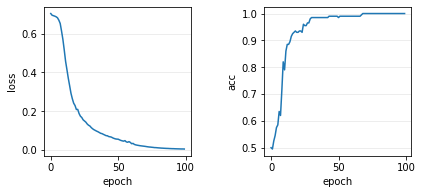

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = CNN(num_features=1)
# move model to the right device
model.to(device)

# define criterion
criterion = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-3, weight_decay=1e-5)

num_epochs = 100
train_loss_list = []
train_acc_list = []
for epoch in range(num_epochs):
        
    model.train()
    
    num_predictions = 0
    running_loss = 0.0
    running_num_correct_preds = 0
    
    for i, (temp_image, temp_label) in enumerate(dataloader_train):
        temp_image, temp_label = temp_image.to(device), temp_label.to(device)
        _,_,_,_,_,_,_,_,temp_output = model(temp_image)
        
        
        loss = criterion(temp_output, temp_label)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        _, predicted_label = torch.max(temp_output, 1)
        
        
        num_correct_preds = (predicted_label == temp_label).sum().item()
        
        num_samples = temp_label.size(0)
        num_predictions += num_samples
        
        running_loss += loss.item() * num_samples
        running_num_correct_preds += num_correct_preds
        
    train_loss = running_loss / num_predictions
    train_acc = running_num_correct_preds / num_predictions
#     print(train_loss)
#     print(train_acc)
    
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(np.arange(num_epochs),train_loss_list)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

ax[1].plot(np.arange(num_epochs),train_acc_list)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

fig.subplots_adjust(left=0.14, bottom=0.29, right=0.99, top=0.98, wspace=0.50 ,hspace=0.20 )

In [6]:
print(model)

CNN(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9, out_features=2, bias=True)
)


In [7]:
state_dict = model.state_dict()

In [ ]:
# torch.save(state_dict, 'trained_model_weights.pth')

In [ ]:
# install saved weights
state_dict = torch.load('trained_model_weights.pth')
model.load_state_dict(state_dict)

In [8]:
def visualize(x):
    model.eval()
    with torch.no_grad():
        y1,z1,s1,y2,z2,s2,y3,z3,y4 = model(x.view(-1,1,patch_size,patch_size))
        
        y4 = F.softmax(y4, dim=1)


    print(torch.max(z1))
    print(torch.max(z2))
    print(torch.max(z3))
        
    fig,ax = plt.subplots(4,5)
    ax[1,0].imshow(x[0,:,:],cmap='gray')
    ax[1,0].set_title('input_image')

    ax[0,1].imshow(state_dict['conv1.weight'][0,0,:,:],cmap='gray')
    ax[0,1].set_title('conv1_filter')

    ax[1,1].imshow(y1[0,0,:,:],cmap='gray')
    ax[1,1].set_title('conv1')

    ax[2,1].imshow(z1[0,0,:,:],cmap='gray',vmin=0,vmax=1)
    ax[2,1].set_title('relu1')

    ax[3,1].imshow(s1[0,0,:,:],cmap='gray',vmin=0,vmax=1)
    ax[3,1].set_title('pool1')

    ax[0,2].imshow(state_dict['conv2.weight'][0,0,:,:],cmap='gray')
    ax[0,2].set_title('conv2_filter')

    ax[1,2].imshow(y2[0,0,:,:],cmap='gray')
    ax[1,2].set_title('conv2')

    ax[2,2].imshow(z2[0,0,:,:],cmap='gray',vmin=0,vmax=2.5)
    ax[2,2].set_title('relu2')

    ax[3,2].imshow(s2[0,0,:,:],cmap='gray',vmin=0,vmax=2.5)
    ax[3,2].set_title('pool2')


    ax[0,3].imshow(state_dict['conv3.weight'][0,0,:,:],cmap='gray')
    ax[0,3].set_title('conv3_filter')

    ax[1,3].imshow(y3[0,0,:,:],cmap='gray')
    ax[1,3].set_title('conv3')

    ax[2,3].imshow(z3,cmap='gray',vmin=0,vmax=7.5)
    ax[2,3].set_title('relu3')

    ax[0,4].imshow(state_dict['fc1.weight'],cmap='gray')
    ax[0,4].set_title('fc1_weight')

    ax[1,4].imshow(y4,cmap='gray',vmin=0,vmax=1)
    ax[1,4].set_title('fc1: {:.1f} - {:.1f}'.format(y4[0,0],y4[0,1]))

    for i in range(4):
        for j in range(5):
    #         ax[i,j].axis('off')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

    ax[0,0].axis('off')
    ax[2,0].axis('off')
    ax[3,0].axis('off')
    ax[3,3].axis('off')
    ax[2,4].axis('off')
    ax[3,4].axis('off')

    fig.tight_layout()
    
    return fig,ax

tensor(3.0773)
tensor(5.5909)
tensor(0.)


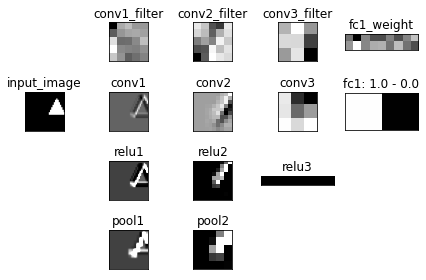

In [9]:
x,y = dataset_train[0]
fig,ax = visualize(x)


tensor(1.8637)
tensor(0.0376)
tensor(1.6910)


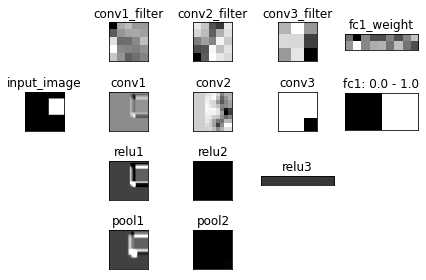

In [10]:
x,y = dataset_train[1]
fig,ax = visualize(x)


tensor(2.4198)
tensor(1.0168)
tensor(1.2512)


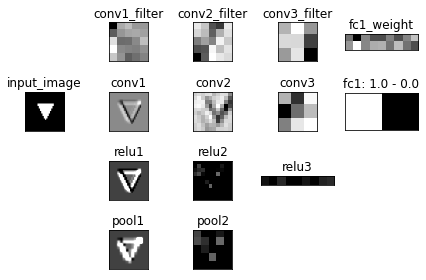

In [11]:
canvas = np.zeros((patch_size,patch_size), dtype=np.float32)

# create a triangle
x,y = 16,16
pts = np.array([[x-offset,y-offset],[x,y+offset],[x+offset,y-offset]],dtype=int)
cv2.drawContours(canvas, [pts], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA


fig,ax = visualize(torch.as_tensor(canvas, dtype=torch.float32).view(-1,patch_size,patch_size))

tensor(2.9241)
tensor(3.3913)
tensor(1.4415)


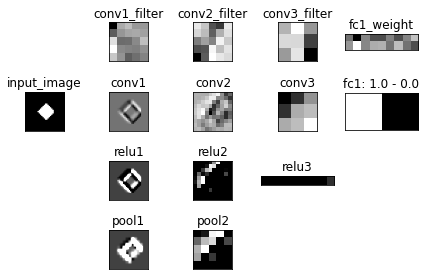

In [12]:
canvas = np.zeros((patch_size,patch_size), dtype=np.float32)

# create a triangle
x,y = 16,16
pts = np.array([[x,y-offset],[x-offset,y],[x,y+offset],[x+offset,y]],dtype=int)
cv2.drawContours(canvas, [pts], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA


fig,ax = visualize(torch.as_tensor(canvas, dtype=torch.float32).view(-1,patch_size,patch_size))

tensor(3.0773)
tensor(5.4232)
tensor(0.8063)


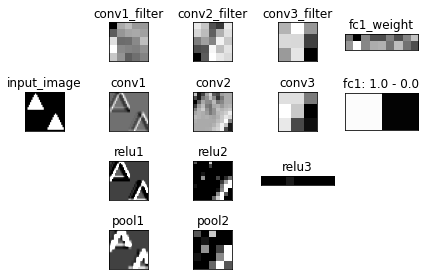

In [13]:
canvas = np.zeros((patch_size,patch_size), dtype=np.float32)

# create a triangle
x,y = 8,8
pts = np.array([[x,y-offset],[x-offset,y+offset],[x+offset,y+offset]],dtype=int)
cv2.drawContours(canvas, [pts], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA

x,y = 24,24
pts = np.array([[x,y-offset],[x-offset,y+offset],[x+offset,y+offset]],dtype=int)
cv2.drawContours(canvas, [pts], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA


fig,ax = visualize(torch.as_tensor(canvas, dtype=torch.float32).view(-1,patch_size,patch_size))

tensor(2.9241)
tensor(0.3156)
tensor(1.6910)


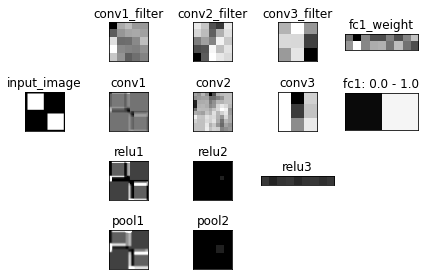

In [14]:
canvas = np.zeros((patch_size,patch_size), dtype=np.float32)

# create a triangle
x,y = 8,8
pts = np.array([[x-offset,y-offset],[x-offset,y+offset],[x+offset,y+offset],[x+offset,y-offset]],dtype=int)
cv2.drawContours(canvas, [pts], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA

x,y = 24,24
pts = np.array([[x-offset,y-offset],[x-offset,y+offset],[x+offset,y+offset],[x+offset,y-offset]],dtype=int)
cv2.drawContours(canvas, [pts], 0, (1), -1, cv2.LINE_4) # cv2.LINE_8, cv2.LINE_AA


fig,ax = visualize(torch.as_tensor(canvas, dtype=torch.float32).view(-1,patch_size,patch_size))